# Forecasting and Analysis on FAANG Stocks

![FAANG](./faang_img.jpeg)

## Goal of this Notebook

The goal of this notebook is to derive insights and conclusions regarding the price of FAANG stocks. To do this, we look at two different models for forecasting closing prices of stocks. The two models we picked were LSTM and Prophet.  We also take a look at the trend of FAANG closing stock prices, historical price to earnings ratios, and attempt to find historical correlations between the highest and lowest percent earning days for each FAANG company. 

## Data Collection
Here, we are loading S&P500 data into a pandas data frame as well as loading all the data for the FAANG companies into a separate data frame.

### Script for collecting up to date data

from datetime import datetime
from concurrent import futures

import pandas as pd
from pandas import DataFrame
import pandas_datareader.data as web

def download_stock(stock):
	""" try to query the iex for a stock, if failed note with print """
	try:
		print(stock)
		stock_df = web.DataReader(stock,'yahoo', start_time, now_time)
		print(stock_df)
		stock_df['Name'] = stock
		output_name = stock + '_data.csv'
		stock_df.to_csv(output_name)
		print("sucess\n\n\n")
	except:
		bad_names.append(stock)
		print('bad: %s' % (stock))

if __name__ == '__main__':

	""" set the download window """
	now_time = datetime.now()
	start_time = datetime(1900,1,1)

	""" list of s_and_p companies """
	s_and_p = ['MMM','ABT','ABBV','ACN','ATVI','AYI','ADBE','AMD','AAP','AES','AET',
		'AMG','AFL','A','APD','AKAM','ALK','ALB','ARE','ALXN','ALGN','ALLE',
		'AGN','ADS','LNT','ALL','GOOGL','GOOG','MO','AMZN','AEE','AAL','AEP',
		'AXP','AIG','AMT','AWK','AMP','ABC','AME','AMGN','APH','APC','ADI','ANDV',
		'ANSS','ANTM','AON','AOS','APA','AIV','AAPL','AMAT','APTV','ADM','ARNC',
		'AJG','AIZ','T','ADSK','ADP','AZO','AVB','AVY','BHGE','BLL','BAC','BK',
		'BAX','BBT','BDX','BRK.B','BBY','BIIB','BLK','HRB','BA','BWA','BXP','BSX',
		'BHF','BMY','AVGO','BF.B','CHRW','CA','COG','CDNS','CPB','COF','CAH','CBOE',
		'KMX','CCL','CAT','CBG','CBS','CELG','CNC','CNP','CTL','CERN','CF','SCHW',
		'CHTR','CHK','CVX','CMG','CB','CHD','CI','XEC','CINF','CTAS','CSCO','C','CFG',
		'CTXS','CLX','CME','CMS','KO','CTSH','CL','CMCSA','CMA','CAG','CXO','COP',
		'ED','STZ','COO','GLW','COST','COTY','CCI','CSRA','CSX','CMI','CVS','DHI',
		'DHR','DRI','DVA','DE','DAL','XRAY','DVN','DLR','DFS','DISCA','DISCK','DISH',
		'DG','DLTR','D','DOV','DWDP','DPS','DTE','DRE','DUK','DXC','ETFC','EMN','ETN',
		'EBAY','ECL','EIX','EW','EA','EMR','ETR','EVHC','EOG','EQT','EFX','EQIX','EQR',
		'ESS','EL','ES','RE','EXC','EXPE','EXPD','ESRX','EXR','XOM','FFIV','FB','FAST',
		'FRT','FDX','FIS','FITB','FE','FISV','FLIR','FLS','FLR','FMC','FL','F','FTV',
		'FBHS','BEN','FCX','GPS','GRMN','IT','GD','GE','GGP','GIS','GM','GPC','GILD',
		'GPN','GS','GT','GWW','HAL','HBI','HOG','HRS','HIG','HAS','HCA','HCP','HP','HSIC',
		'HSY','HES','HPE','HLT','HOLX','HD','HON','HRL','HST','HPQ','HUM','HBAN','HII',
		'IDXX','INFO','ITW','ILMN','IR','INTC','ICE','IBM','INCY','IP','IPG','IFF','INTU',
		'ISRG','IVZ','IQV','IRM','JEC','JBHT','SJM','JNJ','JCI','JPM','JNPR','KSU','K','KEY',
		'KMB','KIM','KMI','KLAC','KSS','KHC','KR','LB','LLL','LH','LRCX','LEG','LEN','LUK',
		'LLY','LNC','LKQ','LMT','L','LOW','LYB','MTB','MAC','M','MRO','MPC','MAR','MMC','MLM',
		'MAS','MA','MAT','MKC','MCD','MCK','MDT','MRK','MET','MTD','MGM','KORS','MCHP','MU',
		'MSFT','MAA','MHK','TAP','MDLZ','MON','MNST','MCO','MS','MOS','MSI','MYL','NDAQ',
		'NOV','NAVI','NTAP','NFLX','NWL','NFX','NEM','NWSA','NWS','NEE','NLSN','NKE','NI',
		'NBL','JWN','NSC','NTRS','NOC','NCLH','NRG','NUE','NVDA','ORLY','OXY','OMC','OKE',
		'ORCL','PCAR','PKG','PH','PDCO','PAYX','PYPL','PNR','PBCT','PEP','PKI','PRGO','PFE',
		'PCG','PM','PSX','PNW','PXD','PNC','RL','PPG','PPL','PX','PCLN','PFG','PG','PGR',
		'PLD','PRU','PEG','PSA','PHM','PVH','QRVO','PWR','QCOM','DGX','RRC','RJF','RTN','O',
		'RHT','REG','REGN','RF','RSG','RMD','RHI','ROK','COL','ROP','ROST','RCL','CRM','SBAC',
		'SCG','SLB','SNI','STX','SEE','SRE','SHW','SIG','SPG','SWKS','SLG','SNA','SO','LUV',
		'SPGI','SWK','SBUX','STT','SRCL','SYK','STI','SYMC','SYF','SNPS','SYY','TROW','TPR',
		'TGT','TEL','FTI','TXN','TXT','TMO','TIF','TWX','TJX','TMK','TSS','TSCO','TDG','TRV',
		'TRIP','FOXA','FOX','TSN','UDR','ULTA','USB','UAA','UA','UNP','UAL','UNH','UPS','URI',
		'UTX','UHS','UNM','VFC','VLO','VAR','VTR','VRSN','VRSK','VZ','VRTX','VIAB','V','VNO',
		'VMC','WMT','WBA','DIS','WM','WAT','WEC','WFC','HCN','WDC','WU','WRK','WY','WHR','WMB',
		'WLTW','WYN','WYNN','XEL','XRX','XLNX','XL','XYL','YUM','ZBH','ZION','ZTS']

	bad_names =[] #to keep track of failed queries

	"""here we use the concurrent.futures module's ThreadPoolExecutor
		to speed up the downloads buy doing them in parallel
		as opposed to sequentially """

	#set the maximum thread number
	max_workers = 50

	workers = min(max_workers, len(s_and_p)) #in case a smaller number of stocks than threads was passed in
	with futures.ThreadPoolExecutor(workers) as executor:
		res = executor.map(download_stock, s_and_p)


	""" Save failed queries to a text file to retry """
	if len(bad_names) > 0:
		with open('failed_queries.txt','w') as outfile:
			for name in bad_names:
				outfile.write(name+'\n')

	#timing:
	finish_time = datetime.now()
	duration = finish_time - now_time
	minutes, seconds = divmod(duration.seconds, 60)
	print('getSandP_threaded.py')
	print(f'The threaded script took {minutes} minutes and {seconds} seconds to run.')
	#The threaded script took 0 minutes and 31 seconds to run.


In [41]:
import glob
import os
import pandas as pd

all_stock_df_list = []
for filename in glob.glob(os.getcwd() +"/data.tmp/raw/"+"*.csv"):
    x = pd.read_csv(filename, low_memory=False)
    all_stock_df_list.append(x)

df = pd.concat(all_stock_df_list)
df.reset_index(inplace=True, drop=True)
df

,Date,High,Low,Open,Close,Volume,Adj Close,Name
0,1977-01-03,25.801493,25.527010,25.527010,25.581905,169800.0,5.956707,XRX
1,1977-01-04,25.691700,25.197628,25.581905,25.252525,143200.0,5.880013,XRX
2,1977-01-05,25.636803,24.923145,25.252525,25.087835,191000.0,5.841664,XRX
3,1977-01-06,25.362318,24.868248,25.087835,25.032938,168700.0,5.828885,XRX
4,1977-01-07,25.142731,24.483971,25.032938,24.923145,143200.0,5.803314,XRX
...,...,...,...,...,...,...,...,...
3741010,2020-11-04,7.870000,7.630000,7.860000,7.640000,67326800.0,7.640000,F
3741011,2020-11-05,7.990000,7.710000,7.760000,7.990000,61442600.0,7.990000,F
3741012,2020-11-06,8.020000,7.750000,8.010000,7.790000,50912100.0,7.790000,F
3741013,2020-11-09,8.380000,8.080000,8.110000,8.200000,110511300.0,8.200000,F


In [42]:
fang = pd.concat([pd.read_csv(f) for f in glob.glob(os.getcwd()+ '/data.tmp/raw/fang/'+'*.csv')], ignore_index = True)
fang.to_csv(os.getcwd()+"/data.tmp/processed/fang.csv",index=False)
fang

,Date,High,Low,Open,Close,Volume,Adj Close,Name
0,2002-05-23,1.242857,1.145714,1.156429,1.196429,104790000.0,1.196429,NFLX
1,2002-05-24,1.225000,1.197143,1.214286,1.210000,11104800.0,1.210000,NFLX
2,2002-05-28,1.232143,1.157143,1.213571,1.157143,6609400.0,1.157143,NFLX
3,2002-05-29,1.164286,1.085714,1.164286,1.103571,6757800.0,1.103571,NFLX
4,2002-05-30,1.107857,1.071429,1.107857,1.071429,10154200.0,1.071429,NFLX
...,...,...,...,...,...,...,...,...
26845,2020-11-04,3244.850098,3139.729980,3159.989990,3241.159912,6839000.0,3241.159912,AMZN
26846,2020-11-05,3366.800049,3288.879883,3319.969971,3322.000000,5789300.0,3322.000000,AMZN
26847,2020-11-06,3322.000000,3232.000000,3304.639893,3311.370117,4647300.0,3311.370117,AMZN
26848,2020-11-09,3289.000000,3112.110107,3231.030029,3143.739990,7190400.0,3143.739990,AMZN


## Stock prediction using LSTM
In this notebook, we have attempted to use LSTM to predict the closing price of FANG stocks. First, we need to include some modules that will be used for the plotting and ML models.

In [43]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
plt.style.use("seaborn-pastel")
%matplotlib inline

from pandas_datareader.data import DataReader
from datetime import datetime


For this example, we will use Apple, Google, Microsoft, Amazon, Facebook, and Netflix. We can use DataReader to get live data from Yahoo on these stocks.

In [44]:
companies = ['AAPL', 'GOOG', 'MSFT', 'AMZN', 'FB', 'NFLX']
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

for ticker in companies:
    globals()[ticker] = DataReader(ticker, 'yahoo', start, end)

We can start by doing analysis on one of the stocks, Amazon. Lets get the stock prices for the past 8 years.

In [45]:
df = DataReader('AMZN', data_source='yahoo', start='2012-01-01', end=datetime.now())
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,179.479996,175.550003,175.889999,179.029999,5110800,179.029999
2012-01-04,180.500000,176.070007,179.210007,177.509995,4205200,177.509995
2012-01-05,178.250000,174.050003,175.940002,177.610001,3809100,177.610001
2012-01-06,184.649994,177.500000,178.070007,182.610001,7008400,182.610001
2012-01-09,184.369995,177.000000,182.759995,178.559998,5056900,178.559998
...,...,...,...,...,...,...
2020-11-09,3289.000000,3112.110107,3231.030029,3143.739990,7190400,3143.739990
2020-11-10,3114.000000,3019.479980,3095.020020,3035.020020,6591000,3035.020020
2020-11-11,3139.149902,3050.000000,3061.780029,3137.389893,4366900,3137.389893


We have information on the high, low, open, close, and volume for each day in the past year. If we look at the plot of the close price (which is what we'll use for analysis), you can see the fluctiation in price.

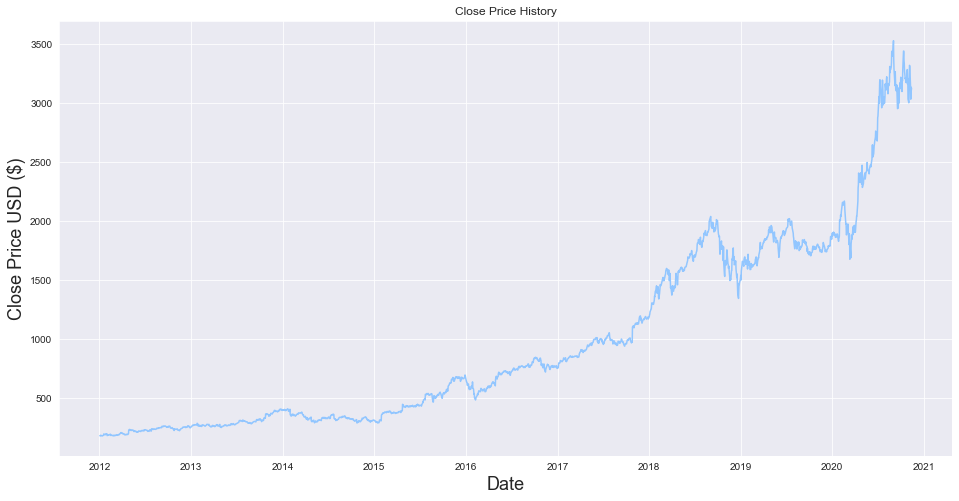

In [46]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

for our dataset, we will just be working with the Close prices. For this example, we can use 60% of the data for training, and 40% for testing.

In [47]:
data = df.filter(['Close'])
dataset = data.values
training_data_len = int(np.ceil( len(dataset) * .6 ))

training_data_len

1340

We need to scale the data so that it is easier to work with in the model.

In [48]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[9.23852679e-04],
       [4.70866468e-04],
       [5.00669928e-04],
       ...,
       [8.82563637e-01],
       [8.74484453e-01],
       [8.80006706e-01]])

Next, let's grab some training data for the model.

In [49]:

train_data = scaled_data[0:int(training_data_len), :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
        
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


Keras makes it easy to implement LSTM.

In [50]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, batch_size=1, epochs=1)

1280/1280 [==============================] - 31s 25ms/step - loss: 1.1807e-04

Finally, we can test the model on the 40% left of the data, and calculate the RMSE.

In [51]:

test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

129.66046791795617

As you can see, our model did pretty well. On average, it predicted a bit low on the closing prices.

<ipython-input-52-de17834f6994>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


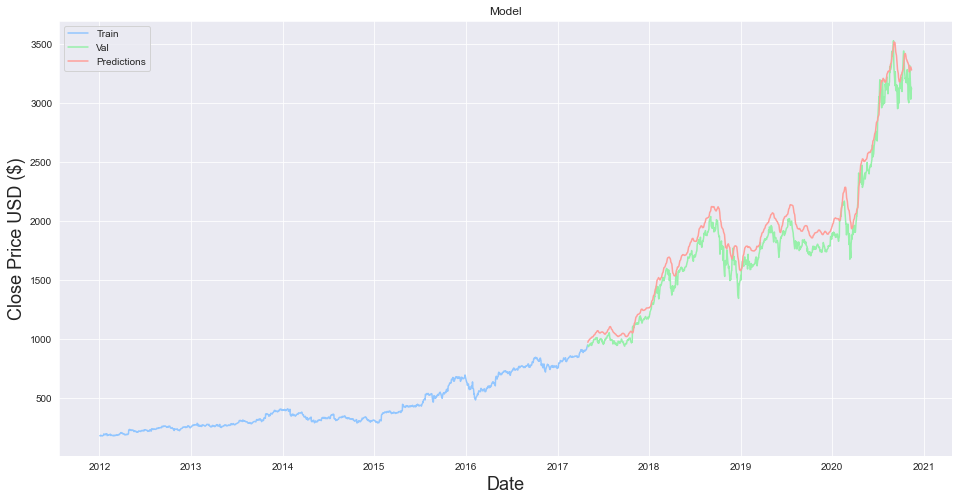

In [52]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper left')
plt.show()

In [53]:
valid

,Close,Predictions
Date,,
2017-05-02,946.940002,971.667847
2017-05-03,941.030029,978.138855
2017-05-04,937.530029,983.829590
2017-05-05,934.150024,988.260498
2017-05-08,949.039978,991.286804
...,...,...
2020-11-09,3143.739990,3301.803223
2020-11-10,3035.020020,3308.619629
2020-11-11,3137.389893,3298.815918


Now let's use the method we just developed again, but on the remaining tickers.

1280/1280 [==============================] - 35s 27ms/step - loss: 1.8573e-04

<ipython-input-54-6a61bcf0e01e>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions
<ipython-input-54-6a61bcf0e01e>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions
<ipython-input-54-6a61bcf0e01e>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

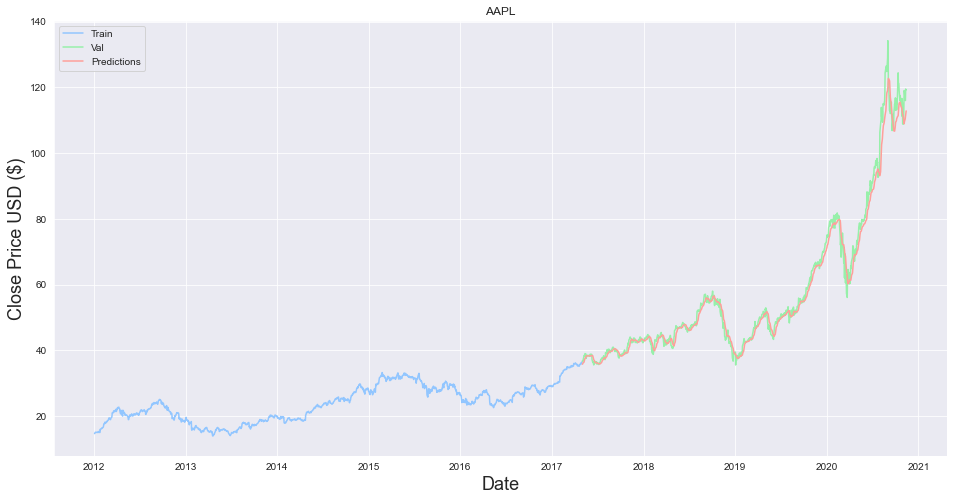

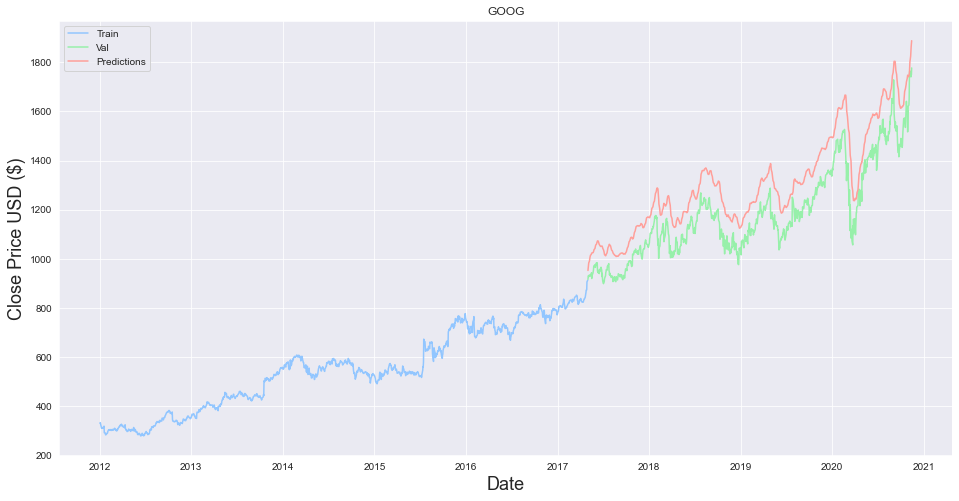

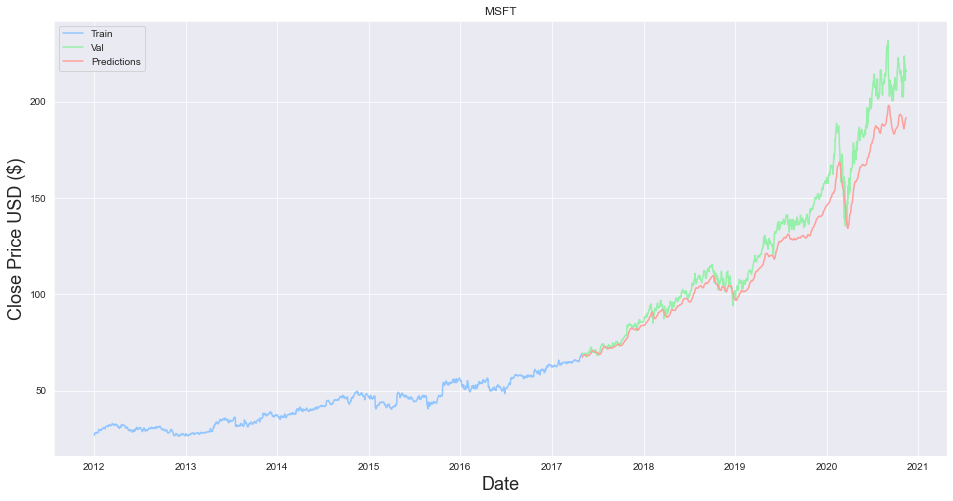

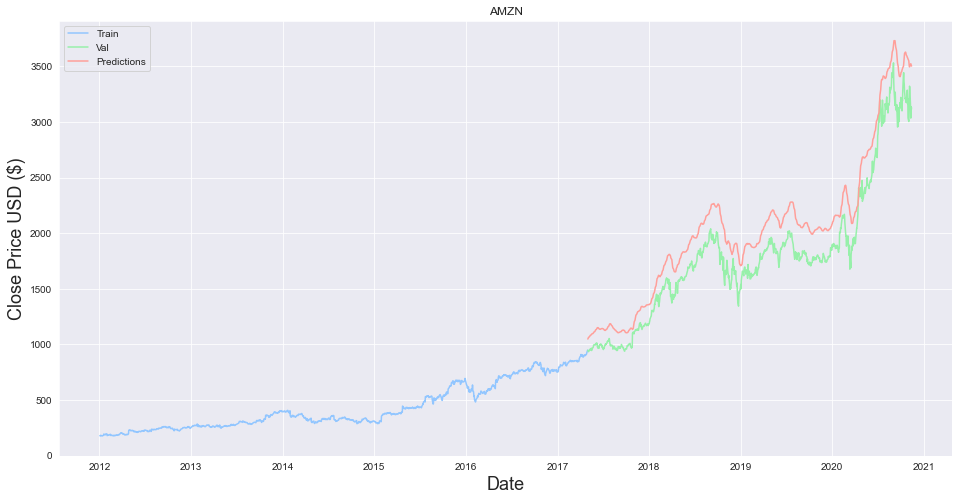

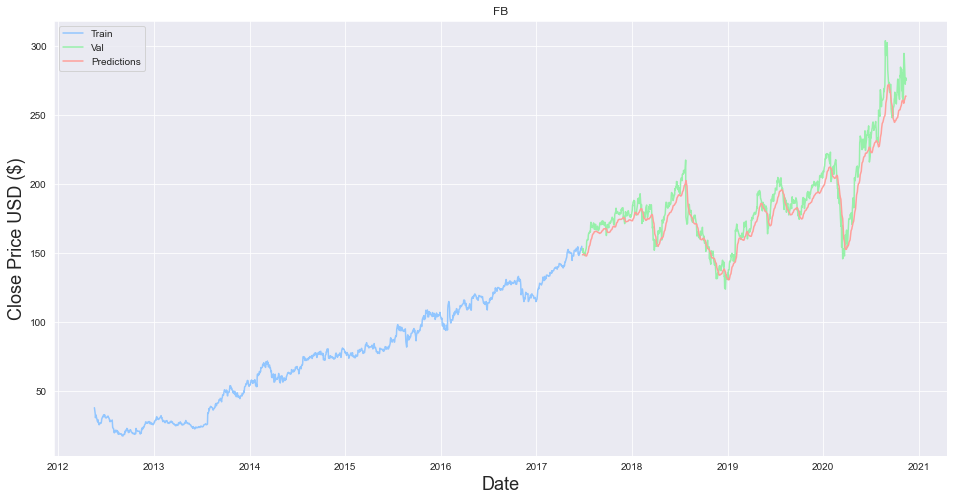

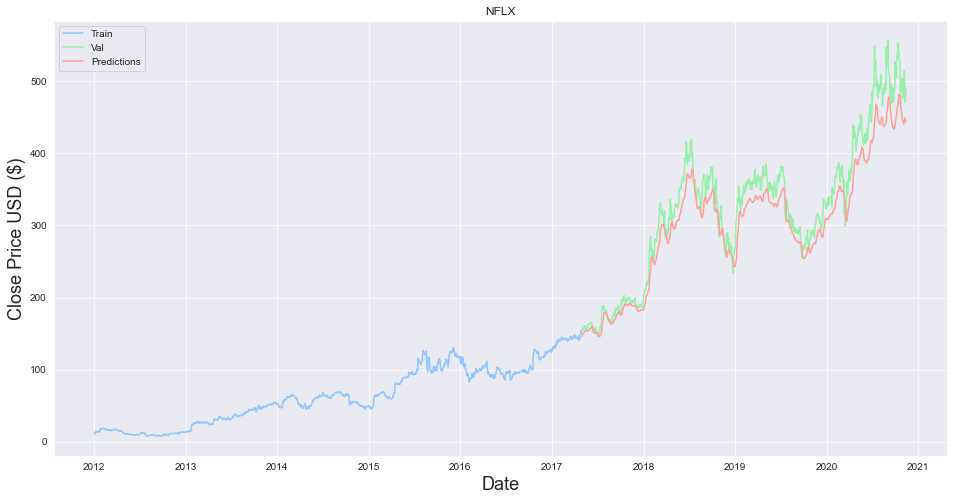

In [54]:
for i, company in enumerate(companies, 1):
    df = DataReader(company, data_source='yahoo', start='2012-01-01', end=datetime.now())
    data = df.filter(['Close'])
    dataset = data.values
    training_data_len = int(np.ceil( len(dataset) * .6 ))

    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)


    train_data = scaled_data[0:int(training_data_len), :]
    x_train = []
    y_train = []

    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
            
    x_train, y_train = np.array(x_train), np.array(y_train)

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
    model.add(LSTM(50, return_sequences= False))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    model.fit(x_train, y_train, batch_size=1, epochs=1)
    test_data = scaled_data[training_data_len - 60: , :]
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
        
    x_test = np.array(x_test)

    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    train = data[:training_data_len]
    valid = data[training_data_len:]
    valid['Predictions'] = predictions
    plt.figure(figsize=(16,8))
    plt.title(company)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='upper left')
    plt.show()

## Forecasting using Prophet

In [55]:
import os
import pandas as pd
import numpy as np

# models
from fbprophet import Prophet

# plots
import matplotlib.pyplot as plt
import seaborn as sns

color = sns.color_palette()
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.


In [56]:
df_faang = pd.read_csv(os.getcwd() +"/data.tmp/processed/fang.csv", low_memory=False)
df_faang.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Name
0,2002-05-23,1.242857,1.145714,1.156429,1.196429,104790000.0,1.196429,NFLX
1,2002-05-24,1.225000,1.197143,1.214286,1.210000,11104800.0,1.210000,NFLX
2,2002-05-28,1.232143,1.157143,1.213571,1.157143,6609400.0,1.157143,NFLX
3,2002-05-29,1.164286,1.085714,1.164286,1.103571,6757800.0,1.103571,NFLX
4,2002-05-30,1.107857,1.071429,1.107857,1.071429,10154200.0,1.071429,NFLX


In [57]:
df_faang.isnull().sum()

Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
Name         0
dtype: int64

There is no empty data. No rows needs to be dropped

In [58]:
df_faang.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26850 entries, 0 to 26849
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       26850 non-null  object 
 1   High       26850 non-null  float64
 2   Low        26850 non-null  float64
 3   Open       26850 non-null  float64
 4   Close      26850 non-null  float64
 5   Volume     26850 non-null  float64
 6   Adj Close  26850 non-null  float64
 7   Name       26850 non-null  object 
dtypes: float64(6), object(2)
memory usage: 1.6+ MB


We need to make change the Date column to Date type and make it to be the index

## Data Cleaning

In [59]:
df_faang["Date"] = pd.to_datetime(df_faang["Date"])
df_faang = df_faang.set_index("Date")
df_faang.head()

,High,Low,Open,Close,Volume,Adj Close,Name
Date,,,,,,,
2002-05-23,1.242857,1.145714,1.156429,1.196429,104790000.0,1.196429,NFLX
2002-05-24,1.225000,1.197143,1.214286,1.210000,11104800.0,1.210000,NFLX
2002-05-28,1.232143,1.157143,1.213571,1.157143,6609400.0,1.157143,NFLX
2002-05-29,1.164286,1.085714,1.164286,1.103571,6757800.0,1.103571,NFLX
2002-05-30,1.107857,1.071429,1.107857,1.071429,10154200.0,1.071429,NFLX


## Seperate the FAANG dataframe

In [60]:
df_facebook = df_faang.loc[df_faang['Name'] == 'FB']
df_apple = df_faang.loc[df_faang['Name'] == 'AAPL']
df_amazon = df_faang.loc[df_faang['Name'] == 'AMZN']
df_netflix = df_faang.loc[df_faang['Name'] == 'NFLX']
df_google = df_faang.loc[df_faang['Name'] == 'GOOGL']

list_faang_df = [
    (df_facebook, 'FB'),
    (df_apple, 'AAPL'),
    (df_amazon, 'AMZN'),
    (df_netflix, 'NFLX'),
    (df_google, 'GOOGL')]

In [61]:
df_google.head()

,High,Low,Open,Close,Volume,Adj Close,Name
Date,,,,,,,
2004-08-19,52.082081,48.028027,50.050049,50.220219,44659000.0,50.220219,GOOGL
2004-08-20,54.594593,50.300301,50.555557,54.209209,22834300.0,54.209209,GOOGL
2004-08-23,56.796795,54.579578,55.430431,54.754753,18256100.0,54.754753,GOOGL
2004-08-24,55.855854,51.836838,55.675674,52.487488,15247300.0,52.487488,GOOGL
2004-08-25,54.054054,51.991993,52.532532,53.053055,9188600.0,53.053055,GOOGL


## Understand more about the data with visualisation

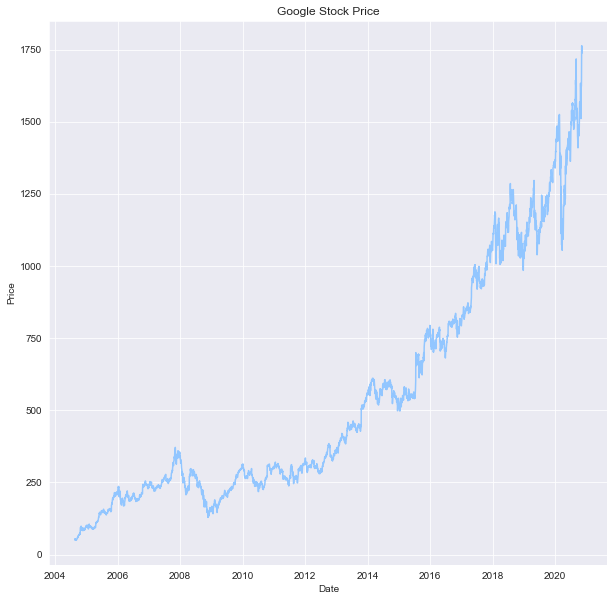

In [62]:
plt.figure(figsize=(10,10))
plt.plot(df_google['Close'])
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Google Stock Price")
plt.show()

Let's explore further

### Moving average
- Moving average is an indicator that smooth the volatility of daily price changes. 
- We will be using simple moving average which is the arithmetic mean over a specfic time period

We will use 50 days and 200 days moving average.

In [63]:
df_google["MA50"] = df_google['Close'].rolling(window=50).mean()
df_google["MA200"] = df_google['Close'].rolling(window=200).mean()
df_google['ewma'] = df_google['Close'].ewm(halflife=0.5, min_periods=20).mean()

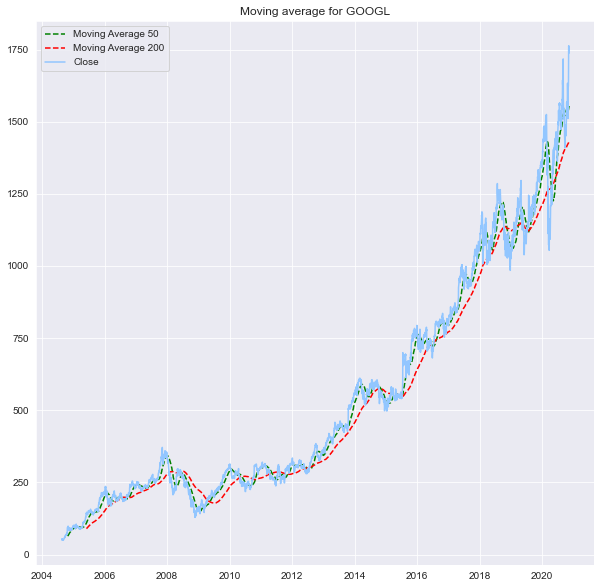

In [64]:
plt.figure(figsize=(10,10))
plt.plot(df_google['MA50'], 'g--', label="Moving Average 50")
plt.plot(df_google['MA200'], 'r--', label="Moving Average 200")
plt.plot(df_google['Close'], label="Close")
plt.title("Moving average for GOOGL")
plt.legend()
plt.show()

## Let's take the last 200 trading days for Moving Average

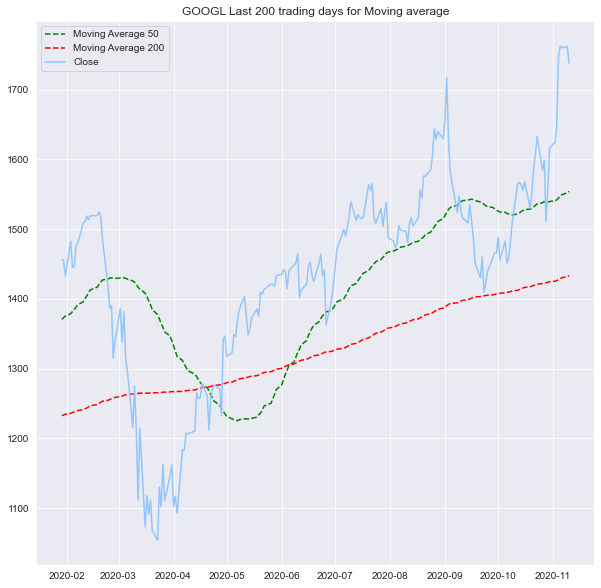

In [65]:
plt.figure(figsize=(10,10))
plt.plot(df_google['MA50'].iloc[-200:], 'g--', label="Moving Average 50")
plt.plot(df_google['MA200'].iloc[-200:], 'r--', label="Moving Average 200")
plt.plot(df_google['Close'].iloc[-200:], label="Close")
plt.title("GOOGL Last 200 trading days for Moving average")
plt.legend()
plt.show()

Moving Average 50 days intersect with Moving Average 200 days. If the MA50 cross above MA200, it is an indication to buy. Otherwise, sell
<br>
### Our data visualisation with moving average indicate that we should buy 

## Explore further with Bollinger Bands

1. Middle Band= 20-day simple moving average (SMA)
2. Upper Band= 20-day SMA+(20-day standard deviation of price x 2)
3. Lower Band= 20-day SMA–(20-day standard deviation of price x 2)

Bollinger Bands illustrate the relative strength or momentum of a stock

In [66]:
df_google['middle_band'] = df_google['Close'].rolling(window=20).mean()
df_google['upper_band'] = df_google['Close'].rolling(window=20).mean() + df_google['Close'].rolling(window=20).std()*2
df_google['lower_band'] = df_google['Close'].rolling(window=20).mean() - df_google['Close'].rolling(window=20).std()*2

## Let's take the last 200 trading days for Bollinger Bands

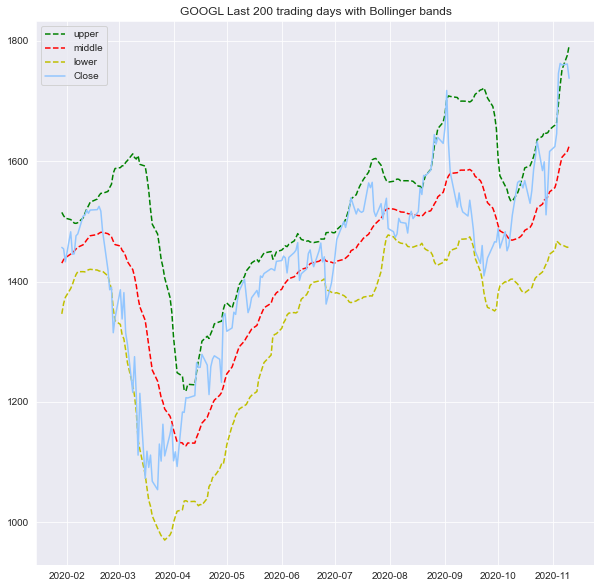

In [67]:
plt.figure(figsize=(10,10))
plt.plot(df_google['upper_band'].iloc[-200:], 'g--', label="upper")
plt.plot(df_google['middle_band'].iloc[-200:], 'r--', label="middle")
plt.plot(df_google['lower_band'].iloc[-200:], 'y--', label="lower")
plt.plot(df_google['Close'].iloc[-200:], label="Close")
plt.title("GOOGL Last 200 trading days with Bollinger bands")
plt.legend()
plt.show()

### From bollinger bands, the trend of GOOGLE stock seems to be increasing 

***
### Use Prophet Model
#### Will GOOGLE stock increase in the future just like what we found out from the data visualization?

In [68]:
df_prophet = df_google.copy()
df_prophet.reset_index(drop=False, inplace=True)
df_prophet = df_prophet[["Date","Close"]]
df_prophet.head()

,Date,Close
0,2004-08-19,50.220219
1,2004-08-20,54.209209
2,2004-08-23,54.754753
3,2004-08-24,52.487488
4,2004-08-25,53.053055


According to Prophet documentation , we have to only have two column with ds and y columns

In [69]:
df_prophet.rename(columns={
    "Date": "ds",
    "Close": "y"
}, inplace=True)
df_prophet.head()

,ds,y
0,2004-08-19,50.220219
1,2004-08-20,54.209209
2,2004-08-23,54.754753
3,2004-08-24,52.487488
4,2004-08-25,53.053055


In [70]:
df_prophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4087 entries, 0 to 4086
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      4087 non-null   datetime64[ns]
 1   y       4087 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 64.0 KB


Reduce the GOOGLE  stock rows to start from 2017-01-01 to the current date

In [71]:
df_prophet = df_prophet.loc[df_prophet["ds"].dt.year >= 2017]
df_prophet.reset_index(drop=True, inplace=True)
df_prophet

,ds,y
0,2017-01-03,808.010010
1,2017-01-04,807.770020
2,2017-01-05,813.020020
3,2017-01-06,825.210022
4,2017-01-09,827.179993
...,...,...
967,2020-11-04,1745.849976
968,2020-11-05,1762.500000
969,2020-11-06,1759.729980
970,2020-11-09,1761.420044


In [72]:
model_prophet = Prophet(daily_seasonality=True)
model_prophet.fit(df_prophet)

In [73]:
future = model_prophet.make_future_dataframe(periods=365) 
prediction = model_prophet.predict(future)

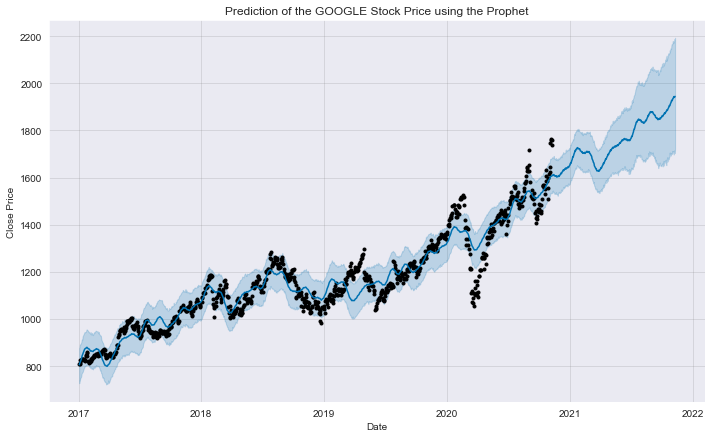

In [74]:
model_prophet.plot(prediction)
plt.title("Prediction of the GOOGLE Stock Price using the Prophet")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

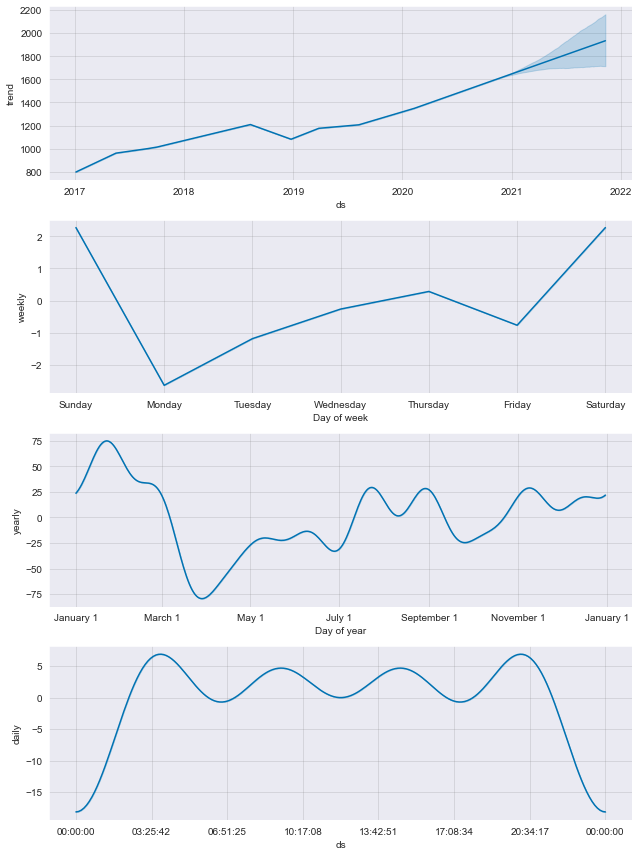

In [75]:
model_prophet.plot_components(prediction)
plt.show()

Based on the estimated trends
- GOOGLE stock price is maximum mostly on Thursday
- Seasonality information indicates it is best to sell in january and buy in April

### Prophet predicts that GOOGLE stock price will increase in the upcoming year which matches up with our prediction from data visualisation

Let's do the prediction for the rest of the tickers


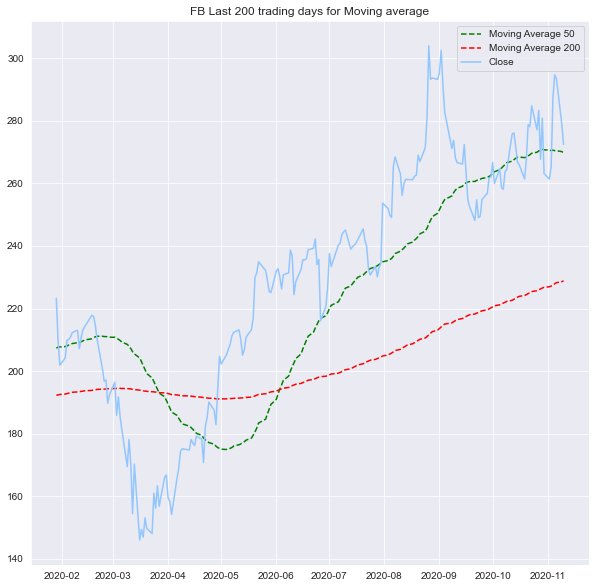

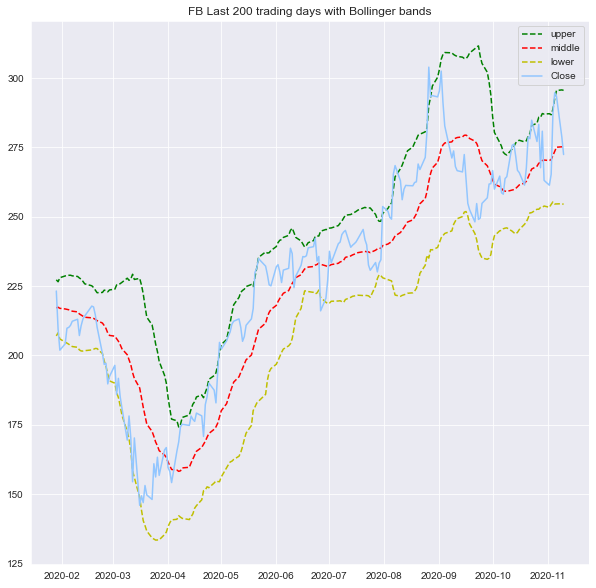

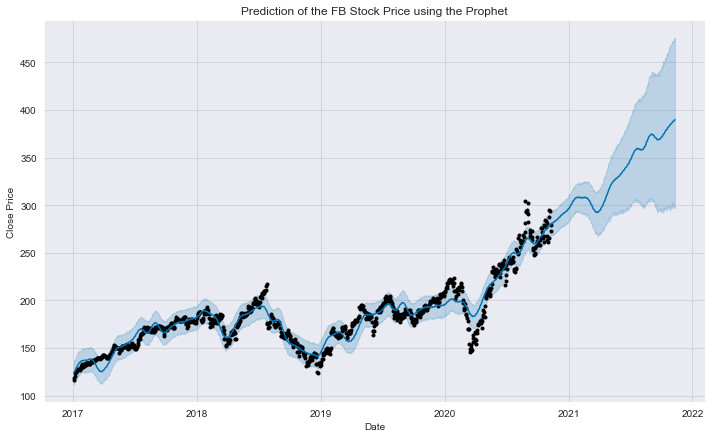

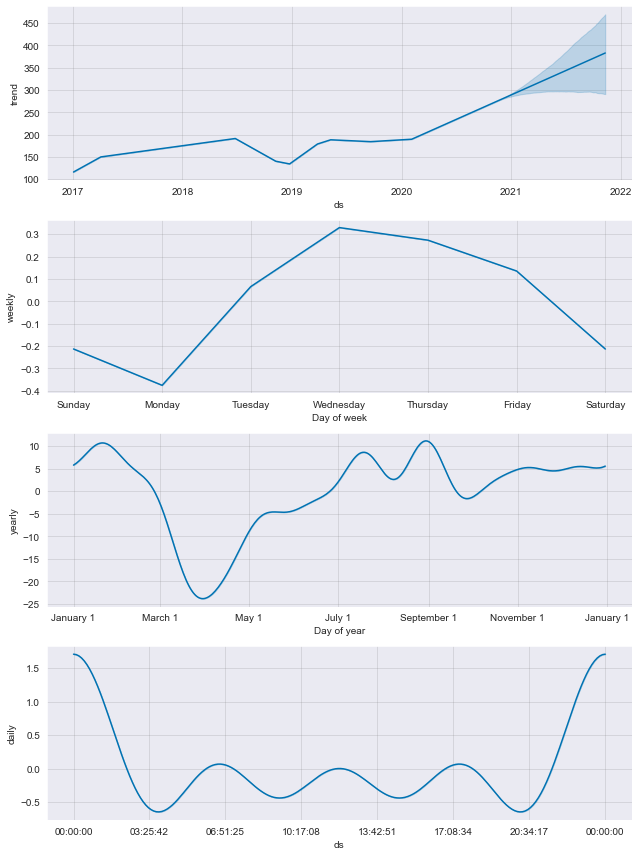

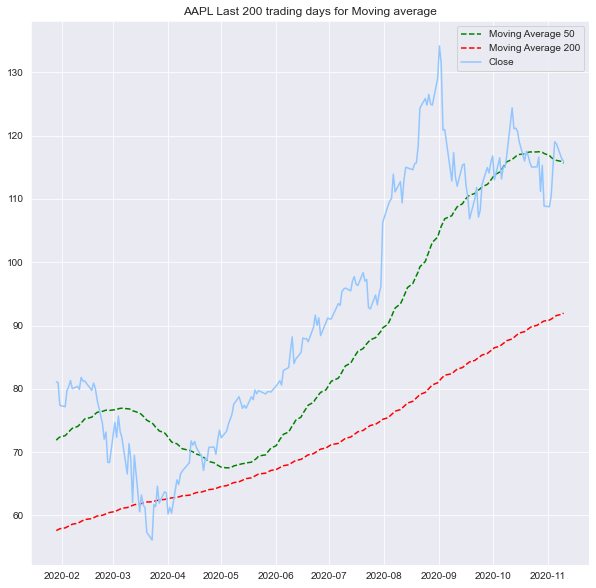

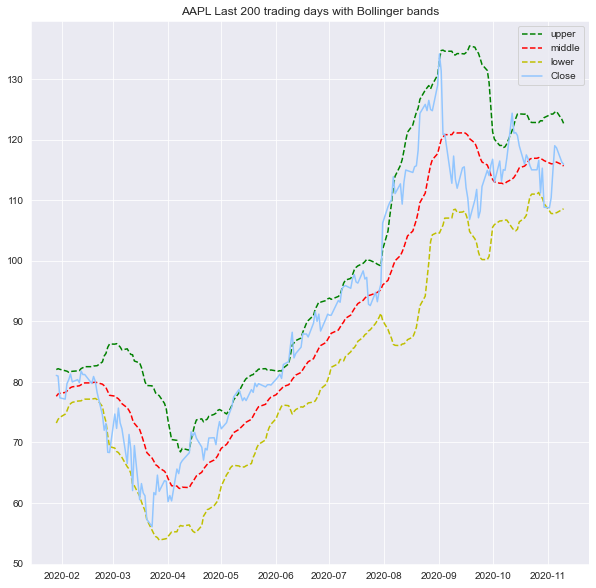

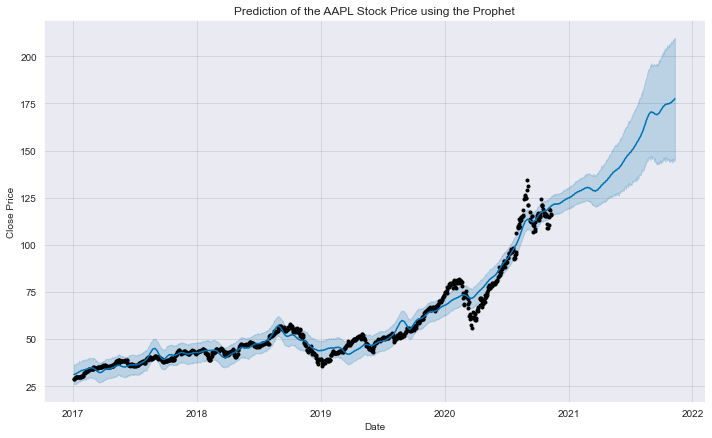

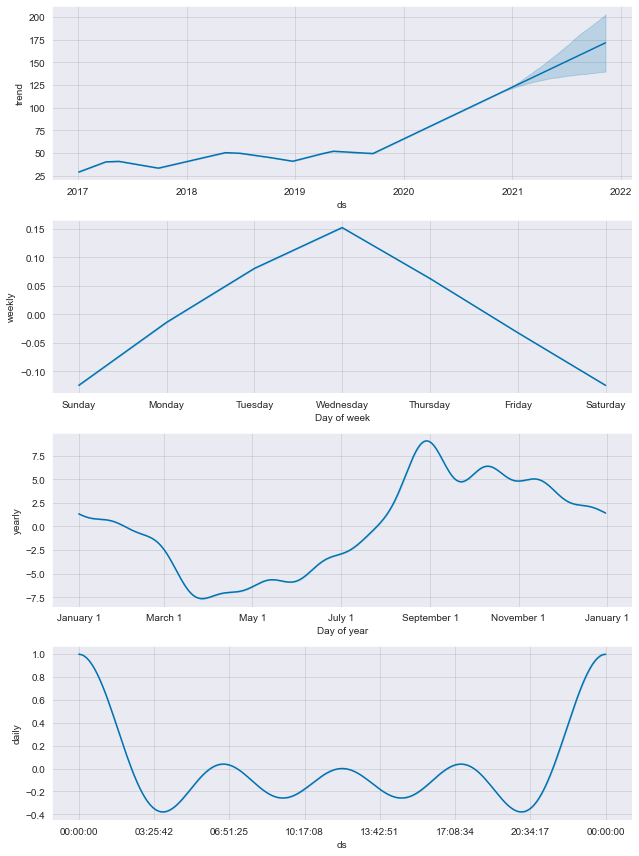

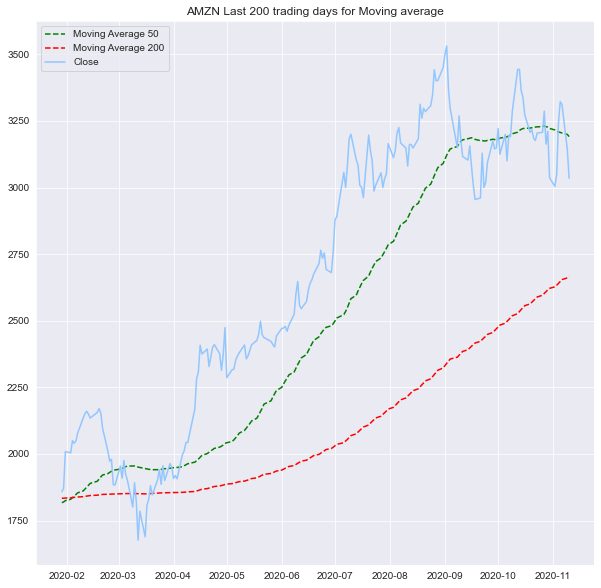

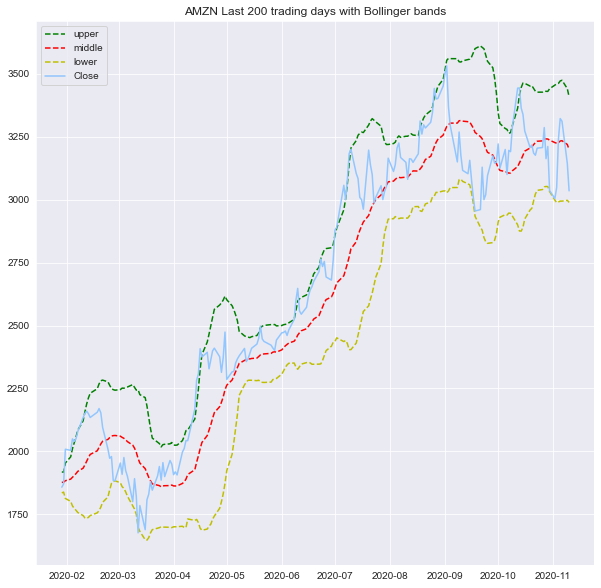

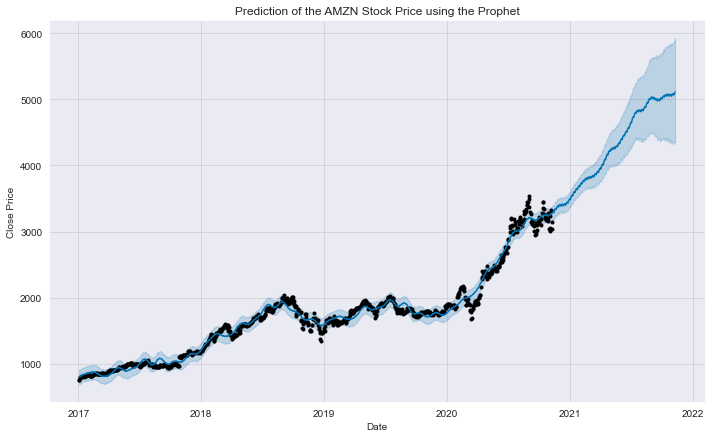

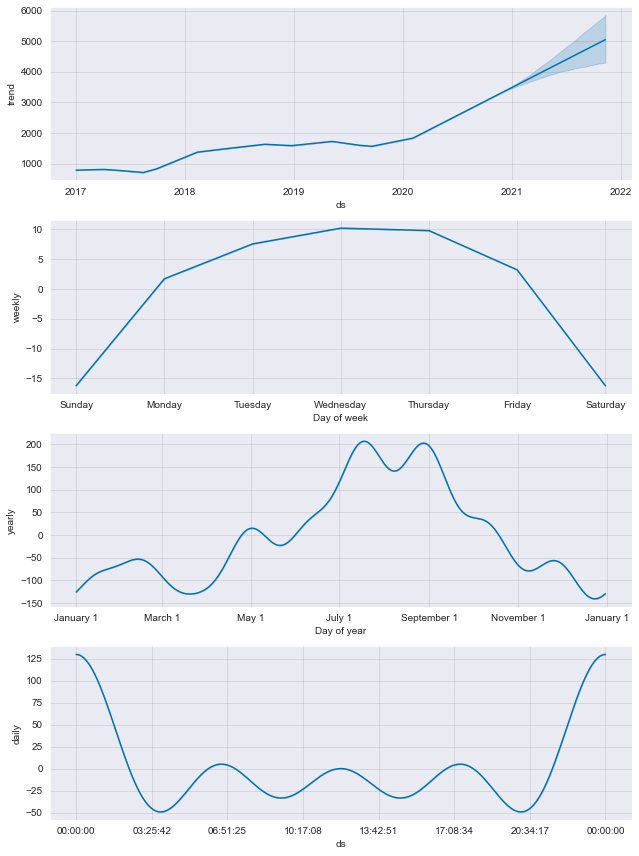

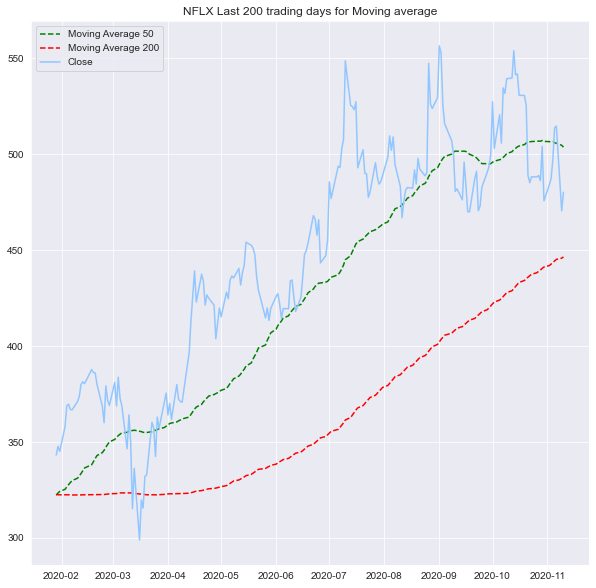

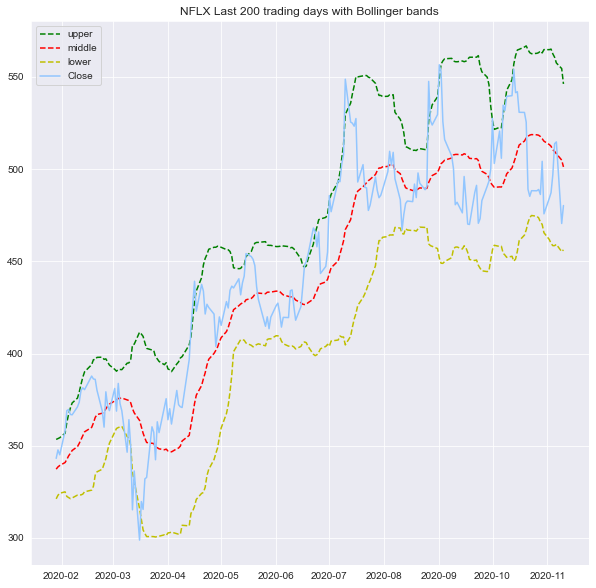

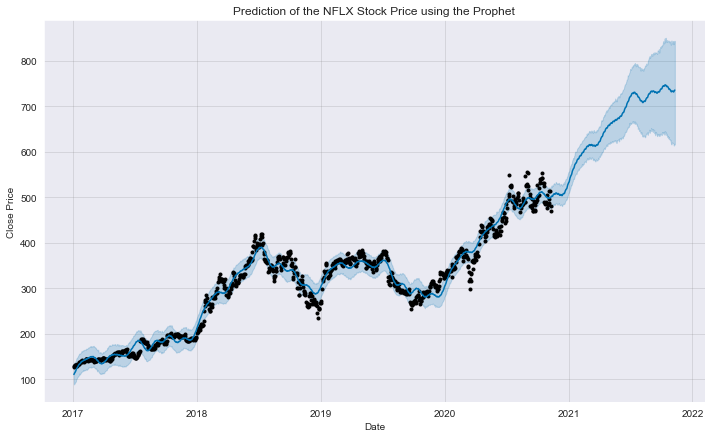

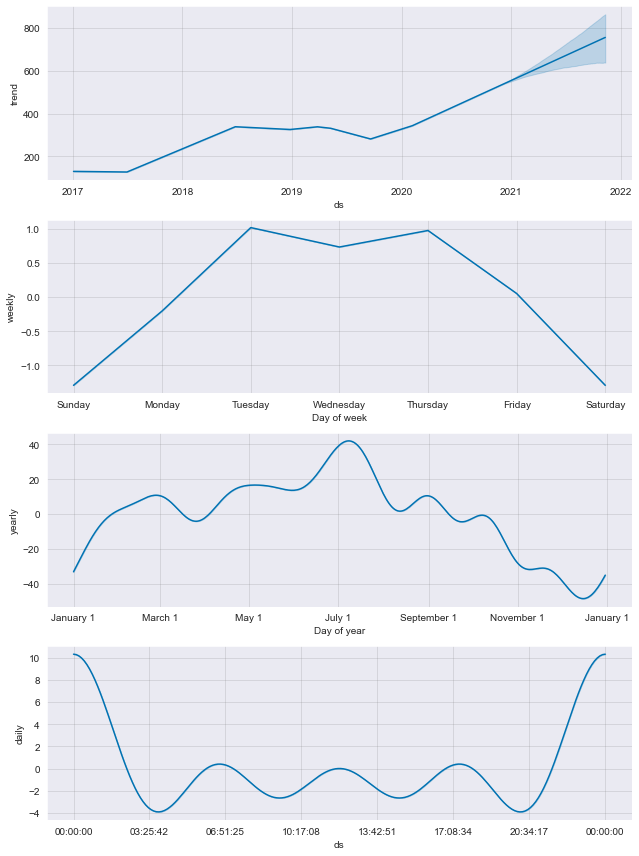

In [76]:
for df, ticker_name in list_faang_df[:-1]:
    
    df["MA50"] = df['Close'].rolling(window=50).mean()
    df["MA200"] = df['Close'].rolling(window=200).mean()
    df['ewma'] = df['Close'].ewm(halflife=0.5, min_periods=20).mean()

    plt.figure(figsize=(10,10))
    plt.plot(df['MA50'].iloc[-200:], 'g--', label="Moving Average 50")
    plt.plot(df['MA200'].iloc[-200:], 'r--', label="Moving Average 200")
    plt.plot(df['Close'].iloc[-200:], label="Close")
    plt.title(f"{ticker_name} Last 200 trading days for Moving average")
    
    plt.legend()
    plt.show()

    df['middle_band'] = df['Close'].rolling(window=20).mean()
    df['upper_band'] = df['Close'].rolling(window=20).mean() + df['Close'].rolling(window=20).std()*2
    df['lower_band'] = df['Close'].rolling(window=20).mean() - df['Close'].rolling(window=20).std()*2

    plt.figure(figsize=(10,10))
    plt.plot(df['upper_band'].iloc[-200:], 'g--', label="upper")
    plt.plot(df['middle_band'].iloc[-200:], 'r--', label="middle")
    plt.plot(df['lower_band'].iloc[-200:], 'y--', label="lower")
    plt.plot(df['Close'].iloc[-200:], label="Close")
    plt.title(f"{ticker_name} Last 200 trading days with Bollinger bands")
    
    plt.legend()
    plt.show()

    df_prophet = df.copy()
    df_prophet.reset_index(drop=False, inplace=True)
    df_prophet = df_prophet[["Date","Close"]]
    df_prophet.head()


    df_prophet.rename(columns={
        "Date": "ds",
        "Close": "y"
    }, inplace=True)


    df_prophet = df_prophet.loc[df_prophet["ds"].dt.year >= 2017]
    df_prophet.reset_index(drop=True, inplace=True)

    model_prophet = Prophet(daily_seasonality=True)
    model_prophet.fit(df_prophet)

    future = model_prophet.make_future_dataframe(periods=365) 
    prediction = model_prophet.predict(future)

    model_prophet.plot(prediction)
    plt.title(f"Prediction of the {ticker_name} Stock Price using the Prophet")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.show()
    
    model_prophet.plot_components(prediction)
    plt.show()
    
    print("=" *90)

### Summary
Based on the estimated trends
- Stock price maximum mostly on:
    - Wednesday for Facebook, Amazon, Apple, Google
    - Thursday for Netflix
- Seasonality information:
    - Buy in April for Facebook, Apple, Amazon, Google
    - Buy in  December for Netflix
    - Sell in January for Facebook, Google
    - Sell in September for Apple, Amazon
    - Sell in July for Netflix

- All FAANG stock price will increase in upcoming future

## Further Analysis
Is there any additional information that we can obtain from this data set?

In [77]:
import glob
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [78]:
data_FAANG = pd.read_csv("data.tmp/processed/fang.csv")
data_FAANG["Date"] = pd.to_datetime(data_FAANG["Date"])
data_FAANG = data_FAANG.set_index("Date")

In [79]:
df_facebook = data_FAANG.loc[df_faang["Name"] == "FB"]
df_apple = data_FAANG.loc[df_faang["Name"] == "AAPL"]
df_amazon = data_FAANG.loc[df_faang["Name"] == "AMZN"]
df_netflix = data_FAANG.loc[df_faang["Name"] == "NFLX"]
df_google = data_FAANG.loc[df_faang["Name"] == "GOOGL"]

## Q1. Whether the Stock Market Is in An Uptrend
 
 Stocks go up because investors are optimistic about the future. This is shown on a stock chart in a number of ways. The most important and easiest way is to look for whether the bottoms on the stock chart are rising and if the market is in a general uptrend (moving from the lower left to the lower right). That means that the buyers are in control of the market, making the stock more likely to go higher than lower.

###  Facebook

In [80]:
df_facebook_uptrend = ((df_facebook["High"] - df_facebook["Low"]) / df_facebook["Volume"]) * 100
df_apple_uptrend = ((df_apple["High"] - df_apple["Low"]) / df_apple["Volume"]) * 100
df_amazon_uptrend = ((df_amazon["High"] - df_amazon["Low"]) / df_amazon["Volume"]) * 100
df_netflix_uptrend = ((df_netflix["High"] - df_netflix["Low"]) / df_netflix["Volume"]) * 100
df_google_uptrend = ((df_google["High"] - df_google["Low"]) / df_google["Volume"]) * 100

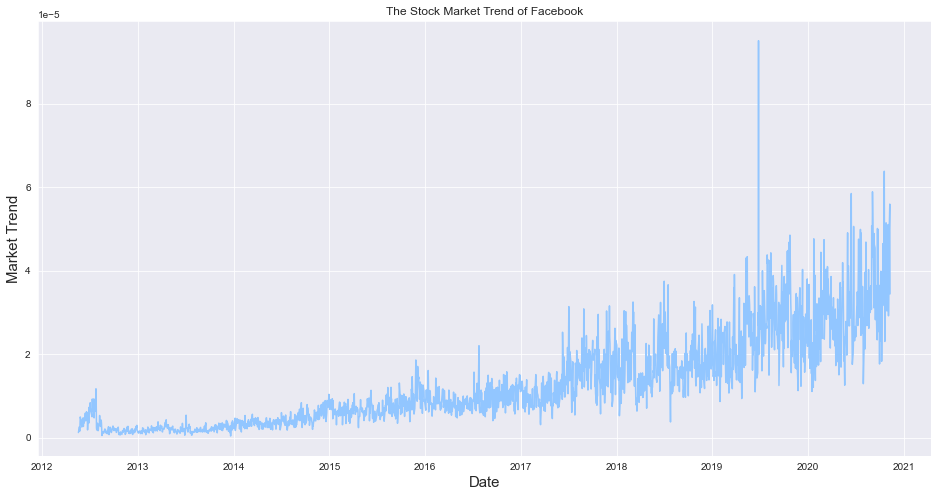

In [81]:
plt.figure(figsize=(16,8))
plt.title("The Stock Market Trend of Facebook")
plt.xlabel("Date", fontsize=15)
plt.ylabel("Market Trend", fontsize=15)
plt.plot(df_facebook_uptrend)
plt.show()

 Facebook's stock market is in an uptrend. As the graph shown above, it is rising and the market is generally in an up trend.

### Apple 

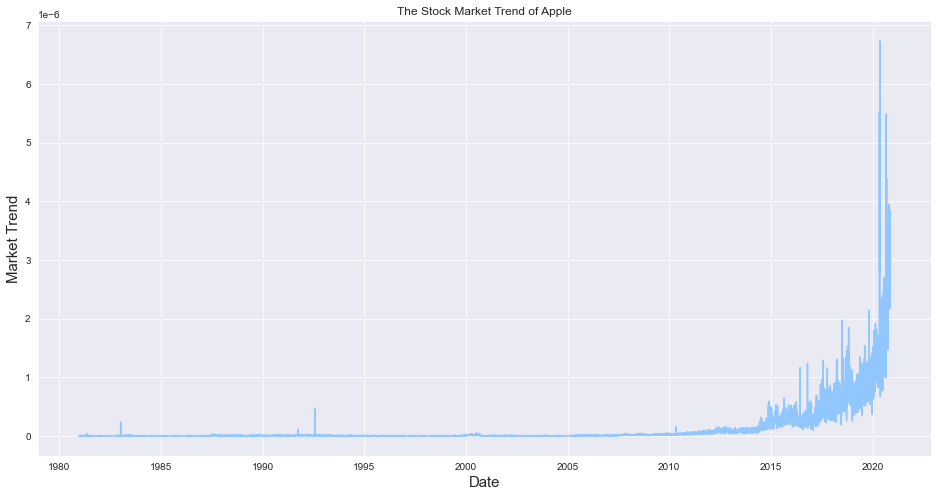

In [82]:
plt.figure(figsize=(16,8))
plt.title("The Stock Market Trend of Apple")
plt.xlabel("Date", fontsize=15)
plt.ylabel("Market Trend", fontsize=15)
plt.plot(df_apple_uptrend)
plt.show()

Apple's stock market is in an extreme uptrend. As the graph shown above, it does not rise until 2010. It rises significantly after 2015.

### Amazon

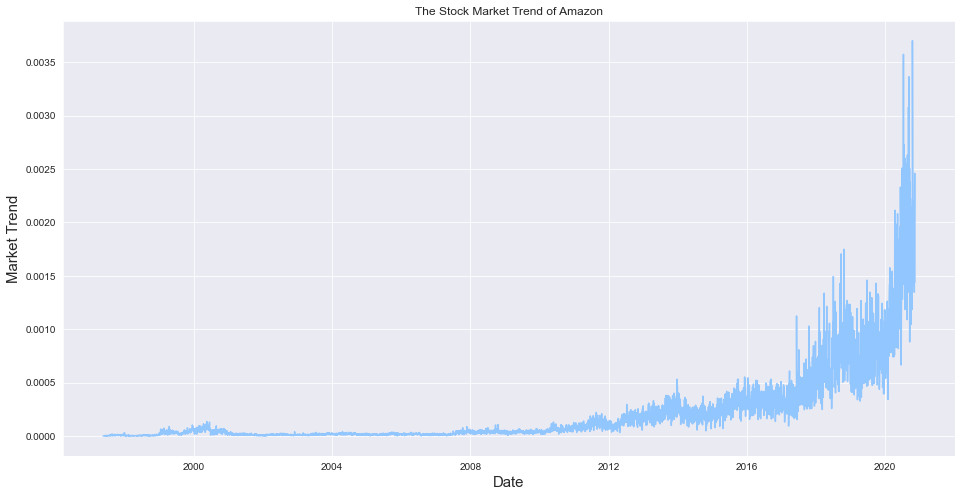

In [83]:
plt.figure(figsize=(16,8))
plt.title("The Stock Market Trend of Amazon")
plt.xlabel("Date", fontsize=15)
plt.ylabel("Market Trend", fontsize=15)
plt.plot(df_amazon_uptrend)
plt.show()

Amazon's stock market is also in an extreme uptrend. As the graph shown above, it does not rise until 2008. It rises significantly after 2016.

### Netflix

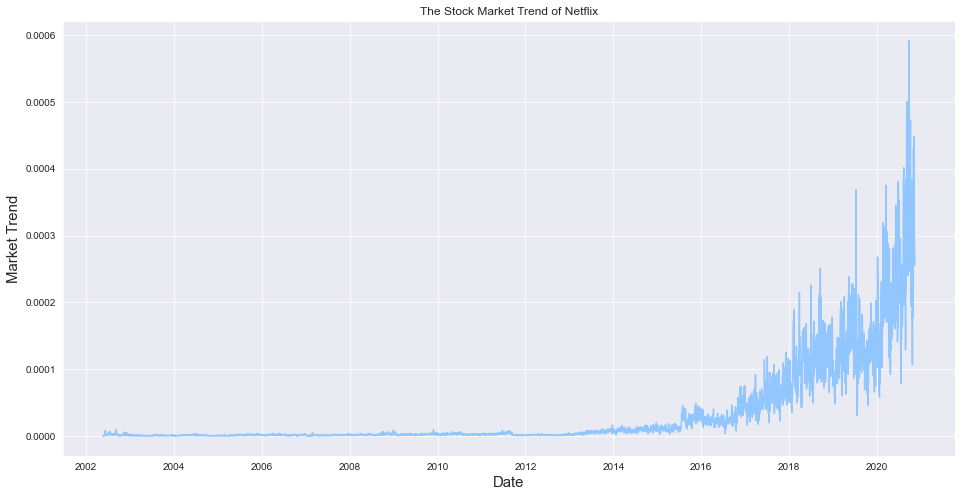

In [84]:
plt.figure(figsize=(16,8))
plt.title("The Stock Market Trend of Netflix")
plt.xlabel("Date", fontsize=15)
plt.ylabel("Market Trend", fontsize=15)
plt.plot(df_netflix_uptrend)
plt.show()

Netfix's stock market is also in an extreme uptrend. As the graph shown above, it does not rise until 2014. It rises significantly after 2016.

### Google

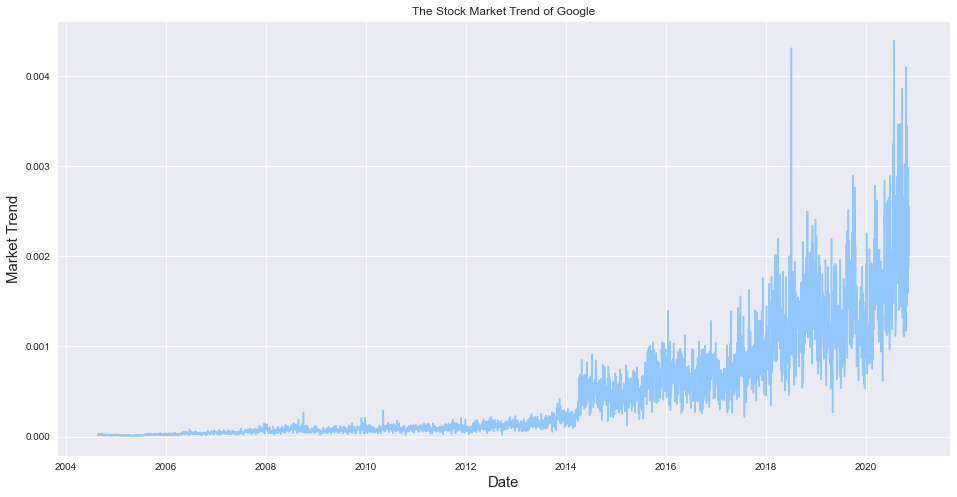

In [85]:
plt.figure(figsize=(16,8))
plt.title("The Stock Market Trend of Google")
plt.xlabel("Date", fontsize=15)
plt.ylabel("Market Trend", fontsize=15)
plt.plot(df_google_uptrend)
plt.show()

Google's stock market is in an uptrend. As the graph shown above, it rises stably and the market is generally in an up trend.

### In Conclusion

FAANG companies all perform pretty well in recent five years. All of their stock prices are in an uptrend obviously. 

## Q2. Is a Stock Worth Buying? 
  There are many ways to evaluate if a stock is worth buying. Historical Price is one of them. If the invester wants to invest a stock for the long term, he/ she needs to do more than look at a single company earnings report or current price performance. Looking at the historical price of last ten years or five years will give him/her a sense of whether a company can withstand tough stretches. However, the historical price are not a guarantee of future performance, but can at minimum be illustrative.
  
  To calculate the historical price of a stock, it requires the PE. ratio from the company so I would use simplified method to replace that complicated formula. 

### Facebook

In [86]:
df_facebook_price = ((df_facebook["High"] - df_facebook["Low"]) / 2) * 100
df_apple_price = ((df_apple["High"] - df_apple["Low"]) / 2) * 100
df_amazon_price = ((df_amazon["High"] - df_amazon["Low"]) / 2) * 100
df_netflix_price = ((df_netflix["High"] - df_netflix["Low"]) / 2) * 100
df_google_price = ((df_google["High"] - df_google["Low"]) / 2) * 100


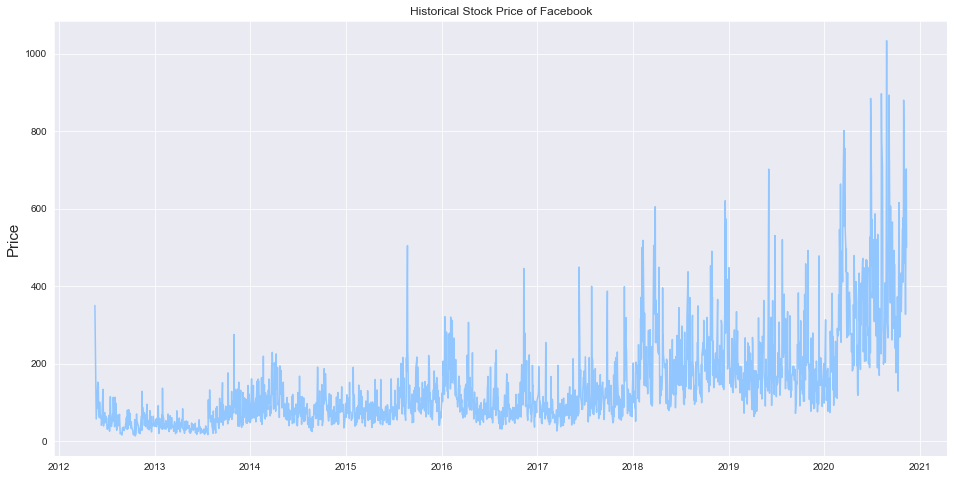

In [87]:
plt.figure(figsize=(16,8))
plt.title("Historical Stock Price of Facebook")
plt.ylabel("Price", fontsize=15)
plt.plot(df_facebook_price)
plt.show()

From the long run, the historical price of Facebook's stock increases even though there are some ups and downs

### Apple 

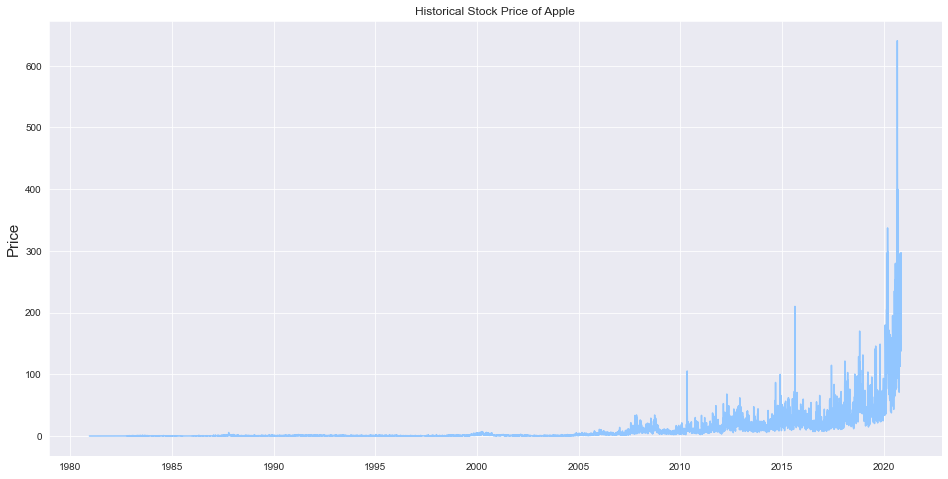

In [88]:
plt.figure(figsize=(16,8))
plt.title("Historical Stock Price of Apple")
plt.ylabel("Price", fontsize=15)
plt.plot(df_apple_price)
plt.show()

After 2005, the historical price of Apple's stock increases significantly.

### Amazon 

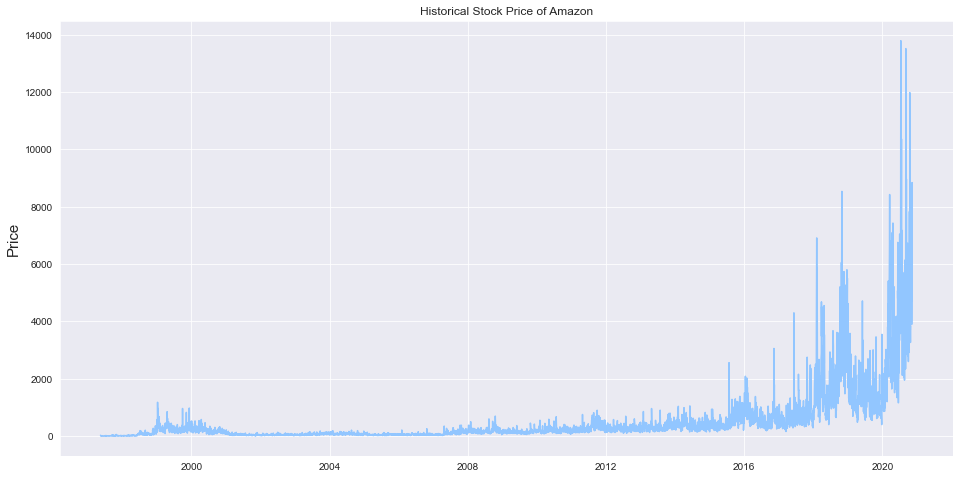

In [89]:
plt.figure(figsize=(16,8))
plt.title("Historical Stock Price of Amazon")
plt.ylabel("Price", fontsize=15)
plt.plot(df_amazon_price)
plt.show()

From the long run, the historical price of Amazon's stock increases especially in the 2020.

### Netflix

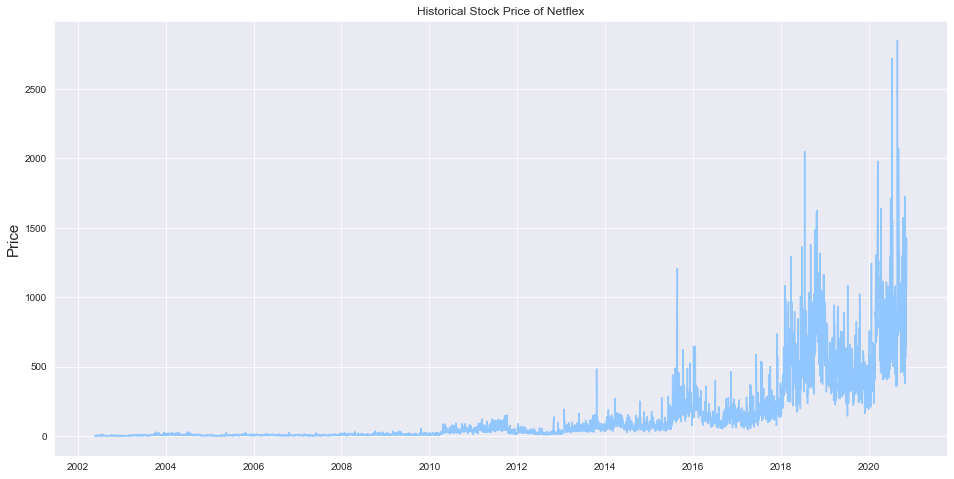

In [90]:
plt.figure(figsize=(16,8))
plt.title("Historical Stock Price of Netflex")
plt.ylabel("Price", fontsize=15)
plt.plot(df_netflix_price)
plt.show()

From the long run, the historical price of Netflix's stock increases. Especially after 2016, it increases significantly.

### Google

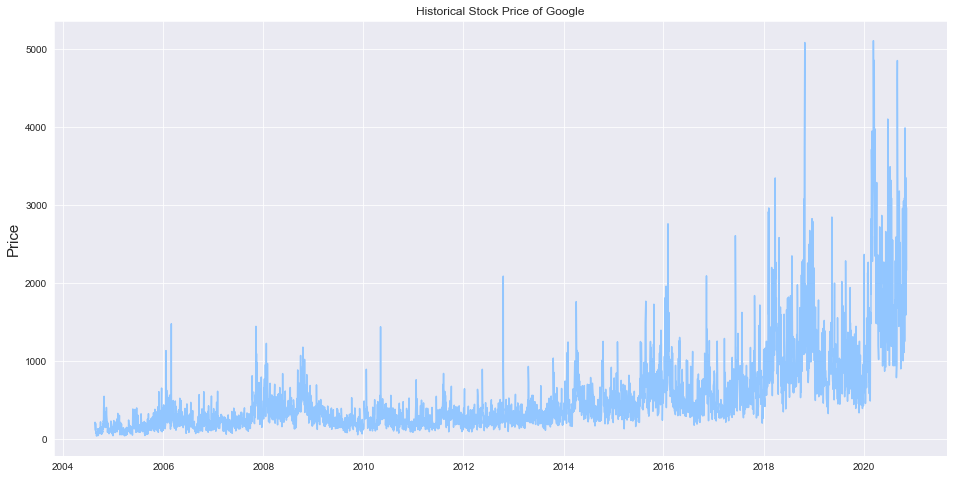

In [91]:
plt.figure(figsize=(16,8))
plt.title("Historical Stock Price of Google")
plt.ylabel("Price", fontsize=15)
plt.plot(df_google_price)
plt.show()

In the long run, the historical price of Google's stock increases even though there are some ups and downs.

In [92]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt

In [93]:
df_faang = pd.read_csv(os.getcwd() +"/data.tmp/processed/fang.csv", low_memory=False)

df_faang["Date"] = pd.to_datetime(df_faang["Date"])
df_faang = df_faang.set_index("Date")

In [94]:
df_facebook = df_faang.loc[df_faang['Name'] == 'FB']
df_apple = df_faang.loc[df_faang['Name'] == 'AAPL']
df_amazon = df_faang.loc[df_faang['Name'] == 'AMZN']
df_netflix = df_faang.loc[df_faang['Name'] == 'NFLX']
df_google = df_faang.loc[df_faang['Name'] == 'GOOGL']

## Q3. Which date provided the highest percentage return / loss for each company?

In [95]:
df_facebook_returns = ((df_facebook['Close'] - df_facebook['Open']) / df_facebook['Open']) * 100
df_apple_returns = ((df_apple['Close'] - df_apple['Open']) / df_apple['Open']) * 100
df_amazon_returns = ((df_amazon['Close'] - df_amazon['Open']) / df_amazon['Open']) * 100
df_netflix_returns = ((df_netflix['Close'] - df_netflix['Open']) / df_netflix['Open']) * 100
df_google_returns = ((df_google['Close'] - df_google['Open']) / df_google['Open']) * 100

### Facebook

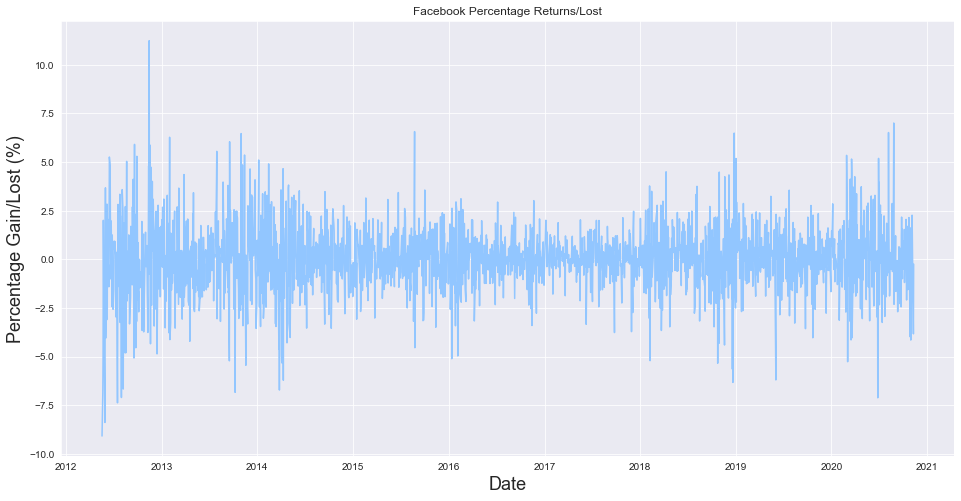

In [96]:
plt.figure(figsize=(16,8))
plt.title('Facebook Percentage Returns/Lost')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Percentage Gain/Lost (%)', fontsize=18)
plt.plot(df_facebook_returns)
plt.show()

In [97]:
print(df_facebook_returns[df_facebook_returns == df_facebook_returns.min()])
print(df_facebook_returns[df_facebook_returns == df_facebook_returns.max()])

Date
2012-05-18   -9.084423
dtype: float64
Date
2012-11-14    11.243782
dtype: float64


On 18 May 2012, Facebook had its highest percentage decrease. They decreased in value by 9.084423%.

On 14 November 2012, Facebook had its highest percentage increase. They increased in value by 11.243782%.

### Apple

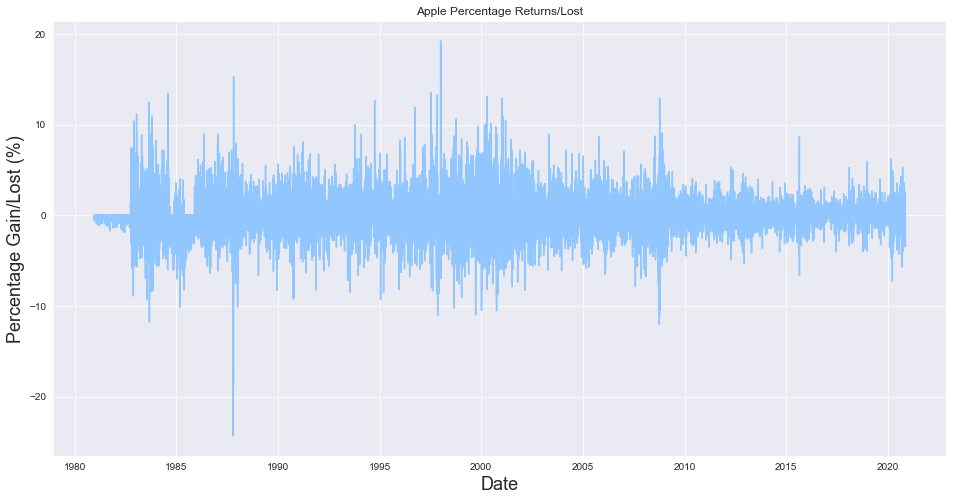

In [98]:
plt.figure(figsize=(16,8))
plt.title('Apple Percentage Returns/Lost')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Percentage Gain/Lost (%)', fontsize=18)
plt.plot(df_apple_returns)
plt.show()

In [99]:
print(df_apple_returns[df_apple_returns == df_apple_returns.min()])
print(df_apple_returns[df_apple_returns == df_apple_returns.max()])

Date
1987-10-19   -24.352329
dtype: float64
Date
1998-01-02    19.266055
dtype: float64


On 19 October 1987, Apple had its highest percentage decrease. They decreased in value by 24.352329%.

On 02 January 1998, Apple had its highest percentage increase. They increased in value by 19.266055%.

### Amazon

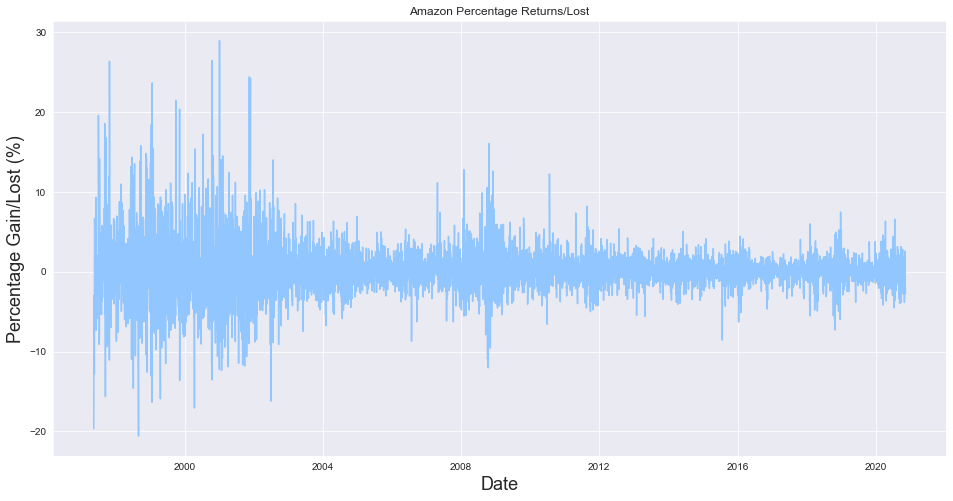

In [100]:
plt.figure(figsize=(16,8))
plt.title('Amazon Percentage Returns/Lost')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Percentage Gain/Lost (%)', fontsize=18)
plt.plot(df_amazon_returns)
plt.show()

In [101]:
print(df_amazon_returns[df_amazon_returns == df_amazon_returns.min()])
print(df_amazon_returns[df_amazon_returns == df_amazon_returns.max()])

Date
1998-08-31   -20.569056
dtype: float64
Date
2001-01-03    28.899083
dtype: float64


On 31 August 1998, Amazon had its highest percentage decrease. They decreased in value by 20.569056%.

On 03 January 2001, Amazon had its highest percentage increase. They increased in value by 28.899083%.

### Netflix

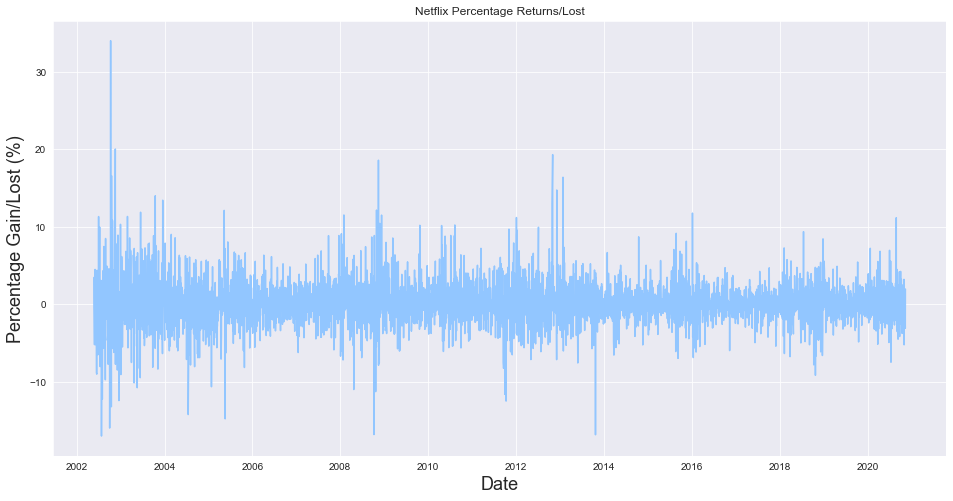

In [102]:
plt.figure(figsize=(16,8))
plt.title('Netflix Percentage Returns/Lost')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Percentage Gain/Lost (%)', fontsize=18)
plt.plot(df_netflix_returns)
plt.show()

In [103]:
print(df_netflix_returns[df_netflix_returns == df_netflix_returns.min()])
print(df_netflix_returns[df_netflix_returns == df_netflix_returns.max()])

Date
2002-07-26   -17.006801
dtype: float64
Date
2002-10-10    34.02647
dtype: float64


On 26 July 2002, Netlix had its highest percentage decrease. They decreased in value by 17.006801%.

On 10 October 2002, Netflix had its highest percentage increase. They increased in value by 34.02647%.

### Google

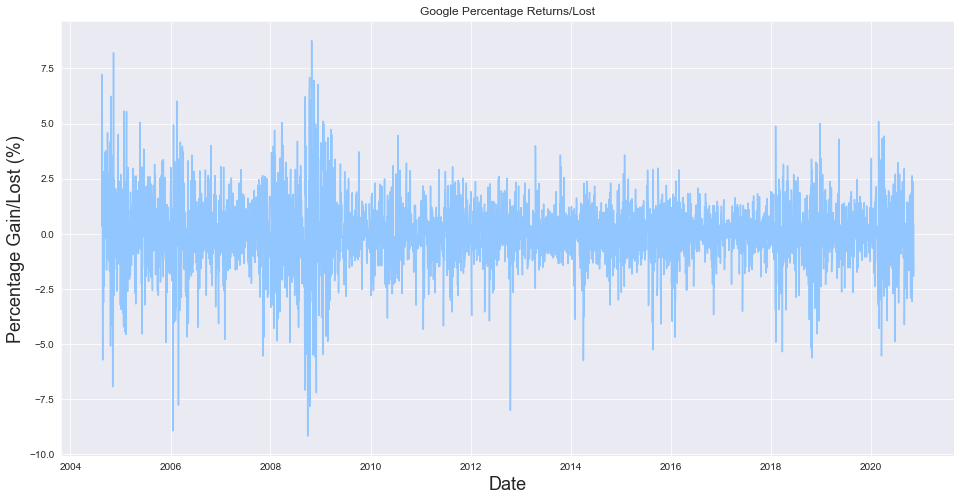

In [104]:
plt.figure(figsize=(16,8))
plt.title('Google Percentage Returns/Lost')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Percentage Gain/Lost (%)', fontsize=18)
plt.plot(df_google_returns)
plt.show()

In [105]:
print(df_google_returns[df_google_returns == df_google_returns.min()])
print(df_google_returns[df_google_returns == df_google_returns.max()])

Date
2008-09-29   -9.179758
dtype: float64
Date
2008-10-28    8.759763
dtype: float64


On 29 September 2008, Google had its highest percentage decrease. They decreased in value by 9.179758%.

On 28 October 2008, Google had its highest percentage increase. They increased in value by 8.759763%.

## Q4. Are there any significance to these dates?

### Facebook
#### 18 May 2012, decreased in value by ~9%

18 May 2012 was Facebook's IPO, the day it made its debut to the stock market. It smashed the record for highest trading volume at that time with 570 million shares being traded. Facebook set its final IPO price at \$38. The first trade came in at \$42. However, it quickly took a reverse dropping down to \$38.23 by the end of the day leading to a final decrease by 9%. 

(Source: https://money.cnn.com/2012/05/18/technology/facebook-ipo-trading/index.htm)

#### 14 November 2012, Increased in value by ~11%

I was not able to find any significant event on 14 November 2012 relating to Facebook. They however did release their 3rd Quarter 2012 results on October 2012 with some great numbers which may have led to the increased in value.

Data Reported:
    * Monthly active users (MAUs) were 1.01 billion as of September 30, 2012, an increase of 26% year-over-year
    * Daily active users (DAUs) were 584 million on average for September 2012, an increase of 28% year-over-year
    * Mobile MAUs were 604 million as of September 30, 2012, an increase of 61% year-over-year 
(Source: https://investor.fb.com/investor-news/press-release-details/2012/Facebook-Reports-Third-Quarter-2012-Results/default.aspx)

### Apple
#### 19 October 1987, decreased in value by ~24%
Black Monday! On 19 October 1987 (also known as the Black Monday) the Dow Jones Industrial Average fell by 508 points ( a 22% decrease). According to Investopedia, Economists have attributed the crash to a combination of geopolitical events and the advent of computerized program trading that accelerated the selloff.

(Source: https://www.investopedia.com/terms/b/blackmonday.asp)

#### 02 January 1998, Increased in value by ~19%
There was not any significant event on 2 January 1998 relating to Apple. However on 10 Novemeber 1997, Apple Computer introduces the Power Macintosh G3 computer, released the PowberBook G3, and Steven Jobs announces further changes to Apple’s corporate strategy. Apple would now sell computers direct, both over the web and the phone, as Power Computing had done so well in the past. This may have attributed to the increase in Apple's value.

(Source: https://igotoffer.com/apple/history-apple-1997-1998)

### Amazon
#### 31 August 1998, decreased in value by ~21%
I was not able to find any significant event on 31 August 1998 relating to Amazon.

#### 03 January 2001, Increased in value by ~29%
There was not any significant event on 03 Januart 2001 but it is important to note that around the year 2000, the dot-com bubble burst destroyed many e-companies in the process, but Amazon survived and moved forward beyond the tech crash to become a huge player in online sales.

(Source: https://www.investopedia.com/terms/d/dotcom-bubble.asp)

### Netflix
#### 26 July 2002, decreased in value by ~17%
I was not able to find any significant event on 26 July 2002 relating to Netflix.

#### 10 October 2002, Increased in value by ~34%
I was not able to find any significant event on 10 October 2002 relating to Netflix.

These dates are however really close to Netflix's IPO date which is on 23 May 2002 which may (or may not) play a part on its volatility.

### Google
#### 29 September 2008, decreased in value by ~9%
On this day, the stock market crashed yet again with the Dow Jones Industrial Average losing nearly 778 points,after the House rejected the government's /$700 billion bank bailout plan.

(Source: https://money.cnn.com/2008/09/29/markets/markets_newyork/)


#### 28 October 2008, Increased in value by ~9/%
On this day, the Dow Jones industrial average added 889 points after having risen as much as 906 points earlier in the session. It was the Dow's second-biggest one-day point gain ever then, following a 936-point rally two weeks ago. The advance of 10.9/% was the sixth-biggest ever then.

(Source: https://money.cnn.com/2008/10/28/markets/markets_newyork/)



## Conclusions

We trained an LSTM and a Prophet model on a dataframe containing FAANG companies using closing prices as the feature we sought to predict. For the LSTM model, we used a mean squared error loss function an were able to obtain reasonable results for all 5 FAANG companies. The LSTM models for each company did a good job of predicting the macro trends related to closing prices. For the prophet model, we were able to do some data visualization beforehand using moving averages and bollinger bands. These two visualizations suggested an upward trend in the stock closing prices. The prophet model itself predicts that all five FAANG stocks will increase in price over the course of the next year. This suggests that all five FAANG companies will be a good investment. By further evaluating the data from the FAANG companies, we were able to see that all five companies have an upward trend. We also looked at the trend of the historical price to earnings ratio and found that all five companies had an upward trend. Lastly, we looked at the days on which each of the FAANG companies had their highest percentage gains and losses and tried to correlate these to real world events. 